In [1]:
import tensorflow as tf

In [2]:
import os

In [3]:
import keras
from keras.models import Sequential, Model
from keras import layers, applications, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random

In [4]:
epoch = 100
batch_size = 256
image_size = 224

In [5]:
#load train data(25000 imgs each)

filenames = os.listdir('./input/train/train')
data = []
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
    
    image = load_img(os.path.join('./input/train/train', filename), color_mode='rgb', target_size=(image_size,image_size))
    image = np.array(image)
    data.append(image)

data = np.array(data)
categories = np.array(categories)

print(data)
print(categories)

[[[[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 203 119]
   [241 202 123]
   [239 200 121]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 205 120]
   [242 203 124]
   [240 201 122]]

  [[203 164  87]
   [206 167  90]
   [209 170  93]
   ...
   [245 204 122]
   [243 204 125]
   [241 202 123]]

  ...

  [[154 123  56]
   [155 124  57]
   [156 125  58]
   ...
   [  3   3   1]
   [  3   3   1]
   [  3   3   1]]

  [[153 122  55]
   [153 122  55]
   [154 123  56]
   ...
   [  2   2   0]
   [  2   2   0]
   [  2   2   0]]

  [[151 120  53]
   [152 121  54]
   [153 122  55]
   ...
   [  1   1   0]
   [  1   1   0]
   [  1   1   0]]]


 [[[ 39  44  40]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [210 209 181]
   [207 204 171]
   [201 199 161]]

  [[ 40  45  41]
   [ 40  44  43]
   [ 41  45  46]
   ...
   [207 203 176]
   [203 200 169]
   [197 195 157]]

  [[ 39  44  40]
   [ 38  42  41]
   [ 37  41  42]
   ...
   [195 191 166]
   [198 193 164]
   [205 200

In [6]:
# shuffle dataset

idx = np.random.permutation(len(data))
data, categories = data[idx], categories[idx]

In [7]:
# split train 6(15,000) / val 2(5,000) / test 2(5,000)

x_train = data[:15000]
y_train = categories[:15000]
x_temp, y_temp = data[-10000:], categories[-10000:]

from sklearn.model_selection import train_test_split

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [8]:
print(x_train, y_train)

print(x_temp, y_temp)
print(x_temp.shape, y_temp.shape)

print(x_val, y_val)

print(x_test, y_test)
print(x_test.shape, y_test.shape)

[[[[ 88 190  55]
   [ 95 191  55]
   [141 231  99]
   ...
   [ 82 158  36]
   [123 195  83]
   [ 58 130  28]]

  [[118 218  86]
   [120 216  80]
   [ 90 180  48]
   ...
   [119 193  78]
   [ 32 103   0]
   [ 43 103  17]]

  [[107 207  75]
   [147 243 109]
   [ 91 183  50]
   ...
   [113 185  77]
   [ 40 107  10]
   [ 30  82   7]]

  ...

  [[100 158  84]
   [ 74 150  59]
   [  7  98   0]
   ...
   [ 17  75  14]
   [  3  59  12]
   [ 43  95  46]]

  [[ 97 158  81]
   [ 48 125  31]
   [ 35 127  20]
   ...
   [ 34  93  29]
   [  3  57   7]
   [ 31  81  32]]

  [[ 38 101  20]
   [ 20 100   1]
   [ 59 151  42]
   ...
   [ 29  89  17]
   [ 33  88  30]
   [ 31  82  26]]]


 [[[250 255 230]
   [244 254 220]
   [245 253 216]
   ...
   [252 251 195]
   [253 252 198]
   [255 254 200]]

  [[248 255 224]
   [245 253 216]
   [245 253 212]
   ...
   [252 250 199]
   [253 251 200]
   [255 253 202]]

  [[246 255 217]
   [245 254 211]
   [244 253 206]
   ...
   [253 251 203]
   [254 252 204]
   [255 252

In [9]:
# data augmentation in train set (train 15,000 to 75,000)

x_train_temp = x_train
y_train_temp = y_train

x_train_aug = []
y_train_aug = []

for img, label in zip(x_train_temp, y_train_temp):
    curImg = img
    
    flipped1 = tf.image.flip_left_right(curImg)
    flipped2 = tf.image.flip_up_down(curImg)
    
    x_train_aug.append(flipped1)
    x_train_aug.append(flipped2)
    
    for i in range(3):
        cropped = curImg[random.randrange(0,100):random.randrange(180,225), random.randrange(0,100):random.randrange(180,225)]
        cropped = cv2.resize(cropped, (image_size, image_size))
        x_train_aug.append(cropped)
    
    for i in range(0, 5):
        y_train_aug.append(label)
        
x_train_aug = np.array(x_train_aug)
y_train_aug = np.array(y_train_aug)

In [10]:
x_train = np.concatenate((x_train, x_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [11]:
print(x_train.shape)
print(y_train.shape)

(90000, 224, 224, 3)
(90000,)


In [12]:
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1):
    x = input_layer
    
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)

    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling')(x)

    return x

In [13]:
def build_vgg(input_shape=(image_size,image_size,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=2):
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
    )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc1')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(4096, activation='relu', kernel_regularizer='l2', name='fc2')(output)
    output = keras.layers.Dropout(0.5)(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [14]:
%load_ext tensorboard

import datetime

In [15]:
model = build_vgg()

In [16]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, clipnorm=1.),
    metrics=['accuracy']
)

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 112, 112, 64)      0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 56, 56, 128)      

In [18]:
log_dir = "logs/vgg_da_new/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_checkpoint = ModelCheckpoint('vgg16.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [20]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)

In [21]:
epoch = 20

history = model.fit(
    x_train, y_train,
    epochs=epoch,
    validation_data=(x_val, y_val),
    verbose=1,
    callbacks=[reduce_lr]
)

Epoch 1/20
2813/2813 [==============================] - 682s 243ms/step - loss: 104.7113 - accuracy: 0.5598 - val_loss: 89.8121 - val_accuracy: 0.6706
Epoch 2/20
2813/2813 [==============================] - 682s 242ms/step - loss: 74.9665 - accuracy: 0.6797 - val_loss: 60.9504 - val_accuracy: 0.7626
Epoch 3/20
2813/2813 [==============================] - 682s 242ms/step - loss: 50.8134 - accuracy: 0.7489 - val_loss: 42.3282 - val_accuracy: 0.7590
Epoch 4/20
2813/2813 [==============================] - 682s 242ms/step - loss: 36.1889 - accuracy: 0.8100 - val_loss: 30.6304 - val_accuracy: 0.8684
Epoch 5/20
2813/2813 [==============================] - 682s 243ms/step - loss: 26.1791 - accuracy: 0.8447 - val_loss: 21.9473 - val_accuracy: 0.8896
Epoch 6/20
2813/2813 [==============================] - 682s 243ms/step - loss: 18.6347 - accuracy: 0.8695 - val_loss: 15.5888 - val_accuracy: 0.8958
Epoch 7/20
2813/2813 [==============================] - 683s 243ms/step - loss: 13.2851 - accuracy:

In [22]:
%tensorboard --logdir logs/vgg_da_new

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 28336.

train loss: 0.12399450689554214
train accuracy: 0.9830666780471802
dev loss: 0.344169557094574
dev accuracy: 0.9376000165939331


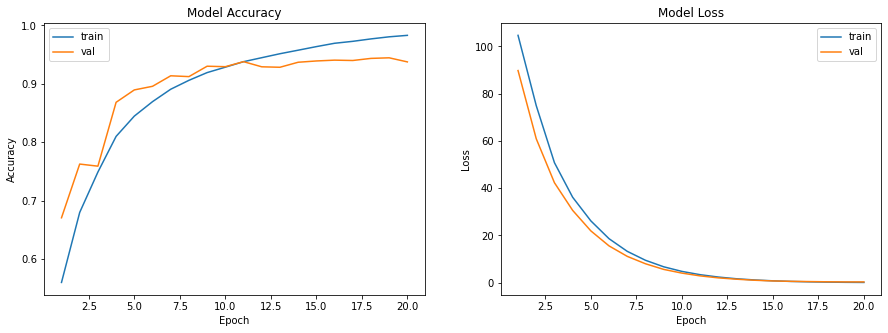

In [23]:
print('train loss:', history.history['loss'][-1])
print('train accuracy:', history.history['accuracy'][-1])

print('dev loss:', history.history['val_loss'][-1])
print('dev accuracy:', history.history['val_accuracy'][-1])

fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(range(1,len(history.history['accuracy'])+1), history.history['accuracy'])
axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

axs[1].plot(range(1,len(history.history['loss'])+1),history.history['loss'])
axs[1].plot(range(1,len(history.history['val_loss'])+1),history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')

plt.show()

In [24]:
model.save('vgg16-dog-cat.h5')

In [25]:
predictions = model.predict(x_test)

In [26]:
print(predictions)

y_pred = []

for i in predictions:
    if i[0] < i[1]:
        y_pred.append(1)
    else:
        y_pred.append(0)

[[2.4623084e-01 7.5376916e-01]
 [6.2745792e-05 9.9993730e-01]
 [9.8697664e-03 9.9013025e-01]
 ...
 [4.0642391e-03 9.9593580e-01]
 [3.6727243e-07 9.9999964e-01]
 [2.1450315e-09 1.0000000e+00]]


In [27]:
from sklearn.metrics import confusion_matrix

confusion_mtx = confusion_matrix(y_test, y_pred)

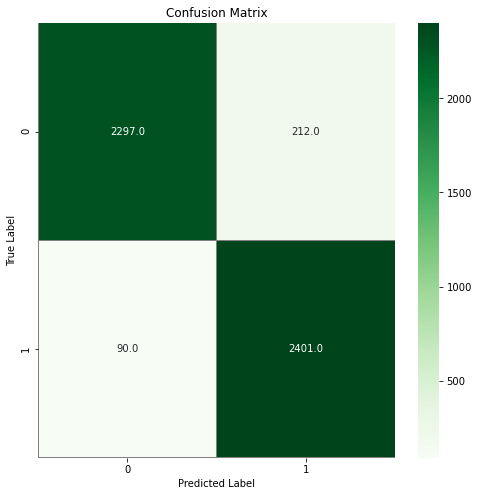

In [28]:
import seaborn as sns

f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [29]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_test, y_pred, target_names=['cat', 'dog'])

In [30]:
print(report)

              precision    recall  f1-score   support

         cat       0.96      0.92      0.94      2509
         dog       0.92      0.96      0.94      2491

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

